In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('Datasets/monthly-sunspots.csv')

#data.drop(['Unnamed: 2'], inplace = True, axis=1)

print(data.head())
print('\nData Types: ')
print(data.dtypes)
print(data.tail())

     Month  Sunspots
0  1749-01      58.0
1  1749-02      62.6
2  1749-03      70.0
3  1749-04      55.7
4  1749-05      85.0

Data Types: 
Month        object
Sunspots    float64
dtype: object
        Month  Sunspots
2815  1983-08      71.8
2816  1983-09      50.3
2817  1983-10      55.8
2818  1983-11      33.3
2819  1983-12      33.4


In [3]:
# convert from dtype: object to time series, date as index
from datetime import datetime
data.columns = ['date', 'value']
data.drop(data.tail(2).index,inplace=True)
print(data)

data['value'] = pd.to_numeric(data.value, errors='coerce')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
#check datatype of index
data.index

         date  value
0     1749-01   58.0
1     1749-02   62.6
2     1749-03   70.0
3     1749-04   55.7
4     1749-05   85.0
...       ...    ...
2813  1983-06   91.1
2814  1983-07   82.2
2815  1983-08   71.8
2816  1983-09   50.3
2817  1983-10   55.8

[2818 rows x 2 columns]


DatetimeIndex(['1749-01-01', '1749-02-01', '1749-03-01', '1749-04-01',
               '1749-05-01', '1749-06-01', '1749-07-01', '1749-08-01',
               '1749-09-01', '1749-10-01',
               ...
               '1983-01-01', '1983-02-01', '1983-03-01', '1983-04-01',
               '1983-05-01', '1983-06-01', '1983-07-01', '1983-08-01',
               '1983-09-01', '1983-10-01'],
              dtype='datetime64[ns]', name='date', length=2818, freq=None)

In [4]:
#convert to time series
OFFSET = 50
data['value'] += OFFSET
ts = data['value']
ts.head(10)
print(data.dtypes)

value    float64
dtype: object


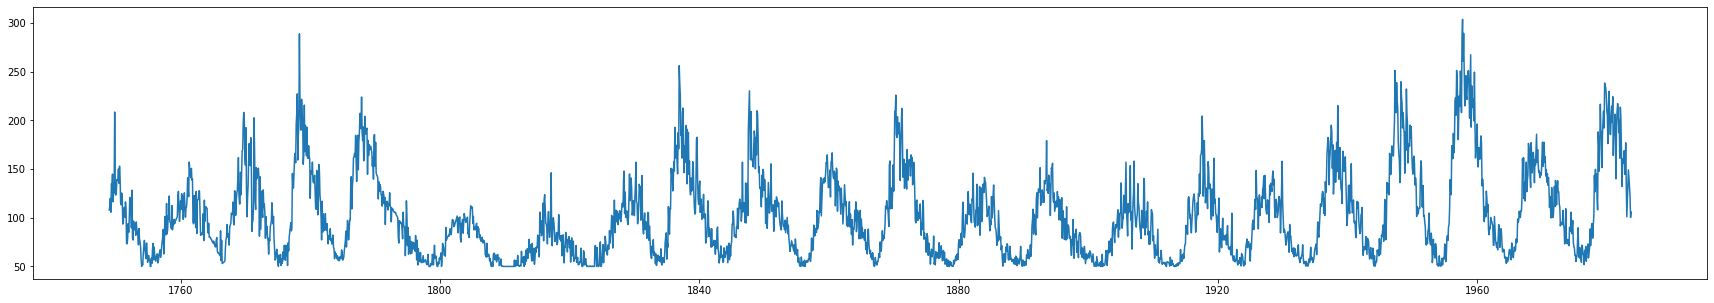

In [5]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(30,5))
plt.plot(ts)
plt.show()



In [6]:
# Missing values
print(data[data.isna().any(axis=1)])
data.bfill(inplace=True)
print(data[data.isna().any(axis=1)])

Empty DataFrame
Columns: [value]
Index: []
Empty DataFrame
Columns: [value]
Index: []


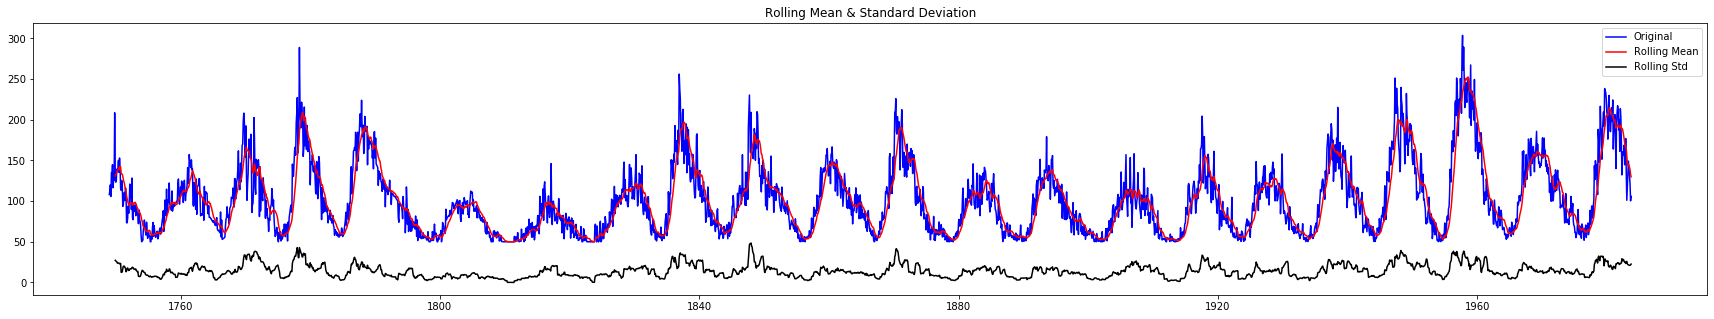

Results of Dickey-Fuller Test:
Test Statistic                -9.504516e+00
p-value                        3.375297e-16
#Lags Used                     2.700000e+01
Number of Observations Used    2.790000e+03
Critical Value (1%)           -3.432696e+00
Critical Value (5%)           -2.862576e+00
Critical Value (10%)          -2.567322e+00
dtype: float64


In [7]:
# Hàm sau đây dùng để plot sự dịch chuyển của mean hoặc độ lệch chuẩn.

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(12).mean()
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(12).std()
#Plot rolling statistics:
    plt.figure(figsize=(30,5))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(ts)

Series([], Name: value, dtype: float64)


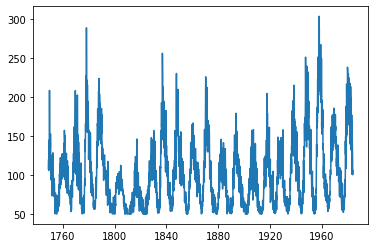

In [8]:
# scales
ts_log = np.log(ts)
plt.plot(ts_log)

print(ts_log[ts_log.isna()])

date
1749-01-01    1.180785
1749-02-01    1.202464
1749-03-01    1.164798
1749-04-01    1.166577
1749-05-01    1.169263
                ...   
1983-06-01    0.814766
1983-07-01    0.838722
1983-08-01    0.813001
1983-09-01    0.806555
1983-10-01    0.840525
Name: value, Length: 2818, dtype: float64

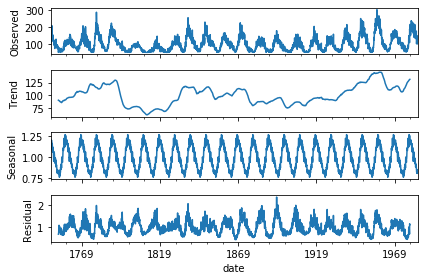

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(ts_log, model='multiplicative', freq = 10 * 12) #chu ky la 10 nam
result_mul.plot()
result_mul.seasonal

Series([], Name: value, dtype: float64)


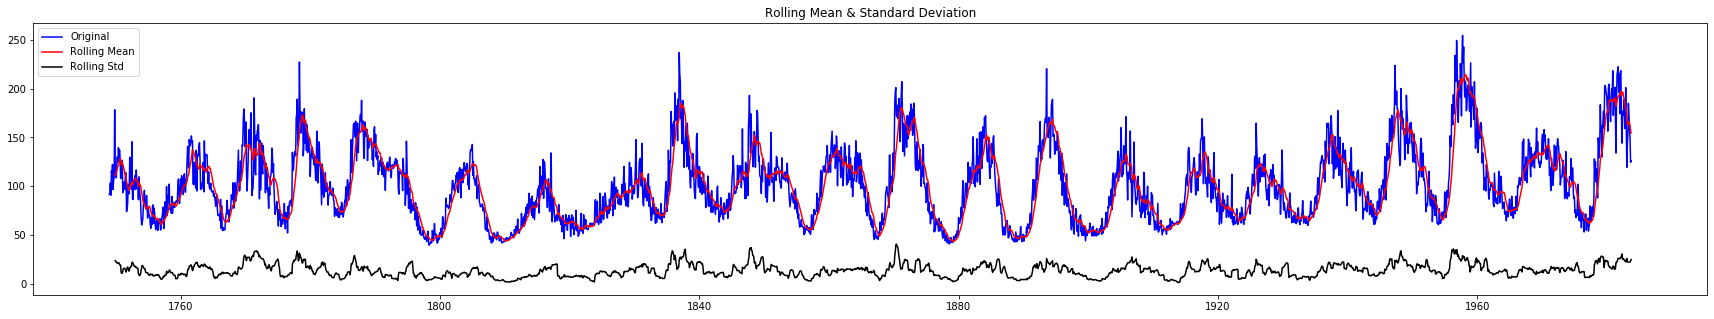

Results of Dickey-Fuller Test:
Test Statistic                -8.638587e+00
p-value                        5.504267e-14
#Lags Used                     2.600000e+01
Number of Observations Used    2.791000e+03
Critical Value (1%)           -3.432695e+00
Critical Value (5%)           -2.862576e+00
Critical Value (10%)          -2.567322e+00
dtype: float64


In [10]:
deseasonaled = ts_log / result_mul.seasonal
#Treat Missing values
deseasonaled.replace([np.inf, -np.inf], np.nan, inplace = True)
deseasonaled.bfill(inplace = True)
print(deseasonaled[np.isnan(deseasonaled)])
test_stationarity(deseasonaled)

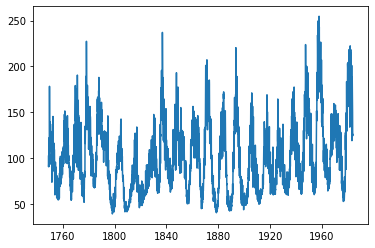

In [11]:
plt.plot(deseasonaled)

In [12]:
# Su dung SVR 

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error

In [13]:
X = deseasonaled.index.values
X = X.reshape(X.shape[0], 1)
y = deseasonaled.values


tmp = np.full(X.shape, X[0])
dt = (X - tmp)

X_days = dt.astype('timedelta64[D]')
X_days = X_days / np.timedelta64(1, 'D')


test_size = 10 * 12
train_size = round(X_days.shape[0] - test_size)
X_train = X_days[:train_size]
y_train = y[:train_size]

X_test = X_days[train_size:]
y_test = y[train_size:]

In [14]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5, 
                   param_grid={"C": [1e2],
                              "epsilon": [0.1]})
svr.fit(X_train, y_train)

print(svr.best_estimator_)
print(svr.best_score_)

SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
-0.18034452813756482


Text(0.5, 1.0, 'MSE: 3662.0375')

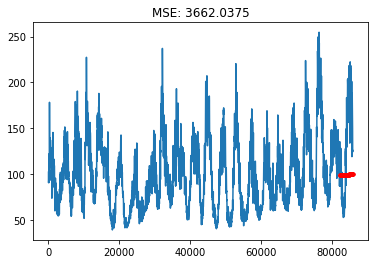

In [15]:
X_test_1 = X_test.copy()
y_predict_1 = np.ndarray((test_size,))
y_truth = y[-test_size:]


for i in range(0, int(test_size)):
    
    train_size_ = round(X_days.shape[0] + i - test_size)
    X_train_1 = X_days[:train_size_].copy()
    y_train_1 = y[:train_size_].copy()
    x = X_test_1[i:i+1].copy()

    #svr = SVR(kernel='rbf', C=0.1, gamma=0.1, epsilon=0)
    y_predict_1[i] = svr.fit(X_train_1, y_train_1).predict(x)
    #print(y_predict_1[i])
    

plt.plot(X_days, y)
plt.plot(X_test_1, y_predict_1, '.r')
plt.title("MSE: %.4f" %mean_squared_error(y_predict_1, y_truth))
  

Text(0.5, 1.0, 'MSE: 3871.3581')

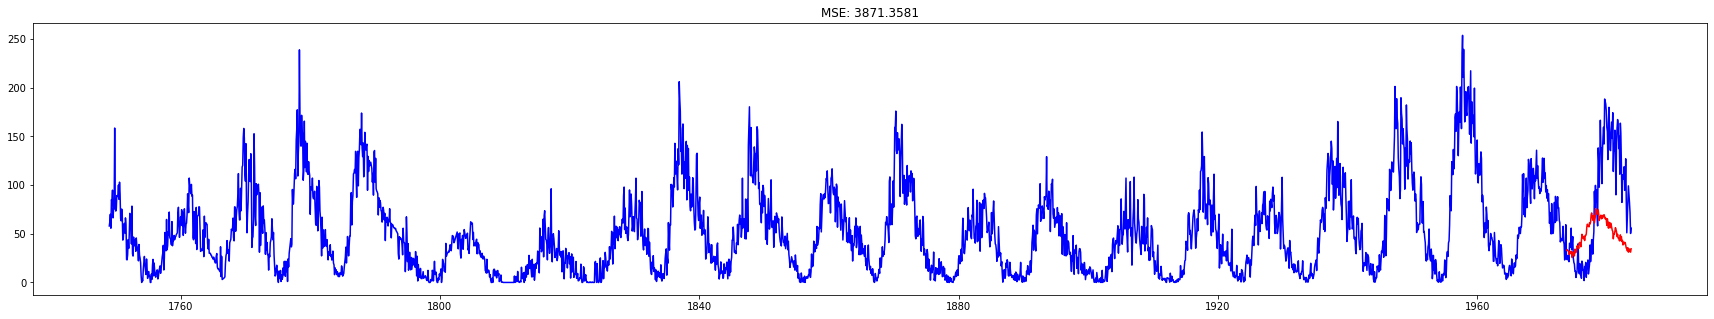

In [16]:
def convert_back(_index, _data, seasonal):
    predictions_SVR_log_deseasonaled = pd.Series(index= _index, data= _data, copy=True)
    predictions_SVR_log = predictions_SVR_log_deseasonaled * seasonal
    predictions_SVR = np.exp(predictions_SVR_log)# 
    return predictions_SVR

predictions_SVR = convert_back(ts_log.index[-test_size:], y_predict_1, result_mul.seasonal)

data['value'] -= OFFSET
predictions_SVR -= OFFSET

plt.figure(figsize=(30,5))
plt.plot(data, color='blue')
predicted_ts = pd.Series(index=ts_log.index, data=predictions_SVR, copy=True)
plt.plot(predicted_ts, color='red')
plt.title("MSE: %.4f" %mean_squared_error(data['value'][-test_size:], predictions_SVR[-test_size:]))

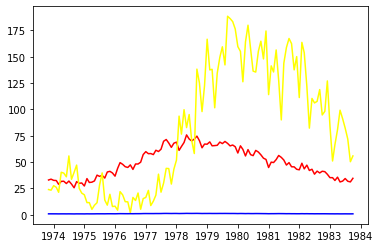

In [17]:
plt.plot(predictions_SVR[-test_size:], color='red')
plt.plot(data['value'][-test_size:], color='yellow')
plt.plot(result_mul.seasonal[-test_size:], color='blue')

In [18]:
#du doan voi n step 

def predict_n_step(X_, y_, test_size, svr):
    train_size = (X_.shape[0] - test_size)
    X_train = X_[:train_size].copy()
    y_train = y_[:train_size].copy()

    X_test = X_[train_size:]
    y_predict = np.ndarray((test_size,))

    for i in range(0, int(test_size)):
        x = X_test[i:i+1]
        
        y_predict[i] = svr.fit(X_train, y_train).predict(x)
        
        np.append(X_train, X_test[i])
        np.append(y_train, y_predict[i])

    return y_predict

Text(0.5, 1.0, 'MSE: 1874.7064')

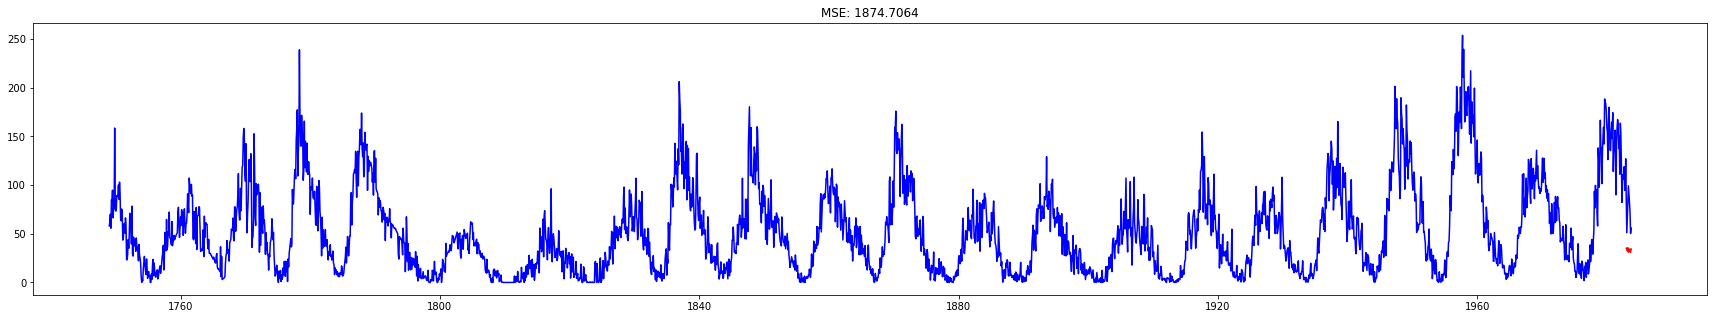

In [19]:
steps = 10
y_predict = predict_n_step(X_days, y, steps, svr)

y_predict = convert_back(ts_log.index[-steps:], y_predict, result_mul.seasonal)
y_predict -= OFFSET

plt.figure(figsize=(30,5))
plt.plot(data, color='blue')
predicted_ts = pd.Series(index=ts_log.index, data=y_predict, copy=True)
plt.plot(predicted_ts, color='red')
plt.title("MSE: %.4f" %mean_squared_error(data['value'][-steps:], y_predict[-steps:]))